# CS437 LAB4 Part 2

### Objectives:
Building an Adaptive Cruise Control based on radar range processing.

### Components needed:
TI radar, laptop with usb port, corner reflectors <br>
*note: open this file in Jupiter notebook to directly run the code.

### Background
In the previous part, we learned how to generate range-profile maps that show the presence of objects at different distances over frames. In this part, we continue building applications on top of the radar range profile map. One popular application of range-based radar processing is adaptive cruise control, in which the car maintains a fixed speed but at the same a safe distance to the car in front, so it automatically adjusts the speed in traffic if it gets too close to the leading car or if the traffic starts moving. To achieve this, the front-facing radar in the car detects the leading car and continously estimates its relative distance.

<img src=acc.gif>

## Excercise 1: Car Detection

In this exercise, we develop an algorithm that detects the leading car and tracks its location over frames. The leading car is essentially the closest large reflector to the radar, which appears as the closest "large" peak in the radar range profile.


Open Visualizer (same as what you've done in prelab), and check "save UART" option.<br>
This will save all the information streamed from radar device.

Next, put the radar port number under COM port section and select and send the "lab4-p2.cfg" configuration file included in this folder. (as shown in the image below). The parameters are set such that the range resolution is 4cm (Bandwidth of 3.4GHz).

Clicking "range" option on the top of the plot will show you the range profile in real time.

Use your corner reflector to act as the leading car to the radar. Move the corner reflector away from the radar from 0.5m to 2m with a relatively fixed speed.  


Visualizer will save the data streamed from radar in every 100 frames.
Ensure you have recorded more than 100 frames, and quit the Visualizer.

You should see the binary file saved under the same directory as the Visualizer.

<img src=image3.png>

Now use the scripts below to parse and visualize the range profiles over frames and verify the distance of the peak from the corner reflector.  

In [1]:
# import required libraries
import struct
import sys
import serial
import binascii
import time
import numpy as np
import math
from scipy import signal

import os
import datetime
import matplotlib.pyplot as plt

# Local File Imports
from parse_bin_output import *

# specify the binary file path below
binFilePath = "./"
output_dict = parse_ADC(binFilePath)
print(f"\neach frame dict contains following informations: {output_dict[0].keys()}")

processing file: ./pHistBytes_1.bin

each frame dict contains following informations: dict_keys(['targetFrameNum', 'header', 'bytes', 'numDetectedPoints', 'pointCloud', 'rangeProfile'])


Add your plotting function from the previous lab here and visualize the range-profile map:



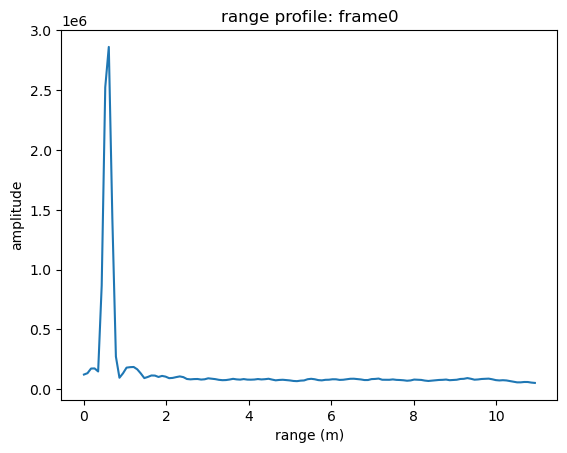

In [2]:
frame_num = 0
range_profile = output_dict[frame_num]['rangeProfile']

#plotting range profile

# define parameters to determine the range:
nFFT = len(range_profile)     # number of FFT bins
fs = 100e6 / 8                  # sampling frequency
c0 = 3e8                        # speed of light
S = 170e12                      # slope of chirp signal
sam_perd = 1/fs
num_ADC = 256
chirp_dur = sam_perd*num_ADC
bandwidth = S*chirp_dur
Dres = c0/(2*bandwidth)

dmax=(fs*c0)/(2*S)
delta_d=dmax/nFFT
# vRange represents the distance vector that will be shown in the x axes of the plot before
vRange = np.arange(nFFT) * delta_d
vRange = vRange[:len(range_profile)]

plt.plot(vRange, range_profile)
plt.xlabel('range (m)')
plt.ylabel('amplitude')
plt.title(f'range profile: frame{frame_num}')

def plot_motion(output_dict):
    '''
    complete this part from the previous lab to draw the range-profile heatmap with range in the y axis, and frames in the x axis and colors show the amplitude values.
    Make sure you set the axes values and correct distances are shown in y axis.
    '''
    distance = []
    for i in range(len(output_dict)):
        distance.append(output_dict[i]['rangeProfile'])
    distance = np.array(distance)
    distance = distance.T
    plt.figure(figsize=(10,10))
    plt.imshow(distance, cmap='jet', aspect='auto')
    plt.xlabel('Frames')
    plt.ylabel('Range')
    plt.title('Range Profile')
    plt.colorbar()
    plt.show()
# plot_motion(output_dict)

### Checkpoint 1 (3 points):

complete the function below to detect the corner reflector peak in each range profile across frames and draw a line plot that shows the distance of the corner reflector over frames.

hint: the max amplitude is not necessarily the corner reflector's reflection as there may be larger objects with stronger peaks. Instead, find the closest peak to the radar.

hint: use functions like scipy.signal.find_peaks to find the peak and define a threshold on the peak amplitude to avoid picking noise instead of the corner reflector.
reference: https://docs.scipy.org/doc/scipy/reference/signal.html#peak-finding


Call a TA to show your system in action.

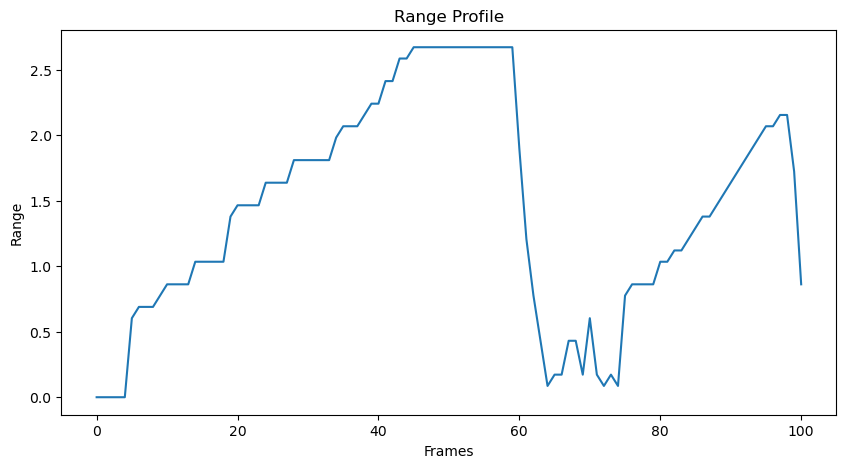

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.60317096, 0.68933824, 0.68933824, 0.68933824, 0.77550551,
       0.86167279, 0.86167279, 0.86167279, 0.86167279, 1.03400735,
       1.03400735, 1.03400735, 1.03400735, 1.03400735, 1.37867647,
       1.46484375, 1.46484375, 1.46484375, 1.46484375, 1.63717831,
       1.63717831, 1.63717831, 1.63717831, 1.80951287, 1.80951287,
       1.80951287, 1.80951287, 1.80951287, 1.80951287, 1.98184743,
       2.06801471, 2.06801471, 2.06801471, 2.15418199, 2.24034926,
       2.24034926, 2.41268382, 2.41268382, 2.58501838, 2.58501838,
       2.67118566, 2.67118566, 2.67118566, 2.67118566, 2.67118566,
       2.67118566, 2.67118566, 2.67118566, 2.67118566, 2.67118566,
       2.67118566, 2.67118566, 2.67118566, 2.67118566, 2.67118566,
       1.89568015, 1.20634191, 0.77550551, 0.4308364 , 0.08616728,
       0.17233456, 0.17233456, 0.4308364 , 0.4308364 , 0.17233456,
       0.60317096, 0.17233456, 0.08616728, 0.17233456, 0.08616

In [9]:
def Car_finder(output_dict):
    '''
    complete this part
    '''
    # Use scipy.signal.find_peaks to find the peaks in the range profile
    # and find the closest peak to the radar
    # return the distance of the closest peak
    distance = []
    for i in range(len(output_dict)):
        distance.append(output_dict[i]['rangeProfile'])
    distance = np.array(distance)
    # distance = distance.T
    # normalize distance for each frame
    distance = distance / np.max(distance, axis=0)

    peaks = []
    for i in range(len(distance)):
        peaks.append(signal.find_peaks(distance[i], height=0.4)[0])
    # print(peaks)
    
    min_distance = [0]
    for i in range(len(peaks)):
        range_profile = output_dict[frame_num]['rangeProfile']

        nFFT = len(range_profile)     # number of FFT bins
        delta_d=dmax/nFFT
        # vRange represents the distance vector that will be shown in the x axes of the plot before
        vRange = np.arange(nFFT) * delta_d
        vRange = vRange[:len(range_profile)]
        
        # find the range value for the closest peak
        min_distance.append(vRange[peaks[i][0]] if len(peaks[i]) > 0 else min_distance[-1])

    # Draw a line plot of the closest peak to the radar
    plt.figure(figsize=(10,5))
    plt.plot(min_distance)
    plt.xlabel('Frames')
    plt.ylabel('Range')
    plt.title('Range Profile')
    plt.show()

    return np.array(min_distance)

Car_finder(output_dict)    


## Exercise 2: Adaptive Cruise Control

Next, we implement a function to find if the leading car is decelerating quickly to activate the break system. One approach is to monitor the distance to the leading car and define a threshold for distance, but that may be too late for a reaction if the car speed is high. Instead, we monitor the relative distance changes to the leading car and react if the distance is changing faster than a threshold.


### Checkpoint 2 (3 points):
Complete the function below that calls Car_finder to get the estimated distance of the corner reflector over frames and measure the amount of displacements between frames. Detect if the car (aka the corner reflector) is approaching and if the approaching speed is above a threshold, print an alert message. <br>

Emulate the scenario and call TAs to show your system in action. The alert should only trigger if the car/corner reflector is approaching and not when it moves away.

hint: You can use the estimated distance between every two consecutive frame to measure the displacements.

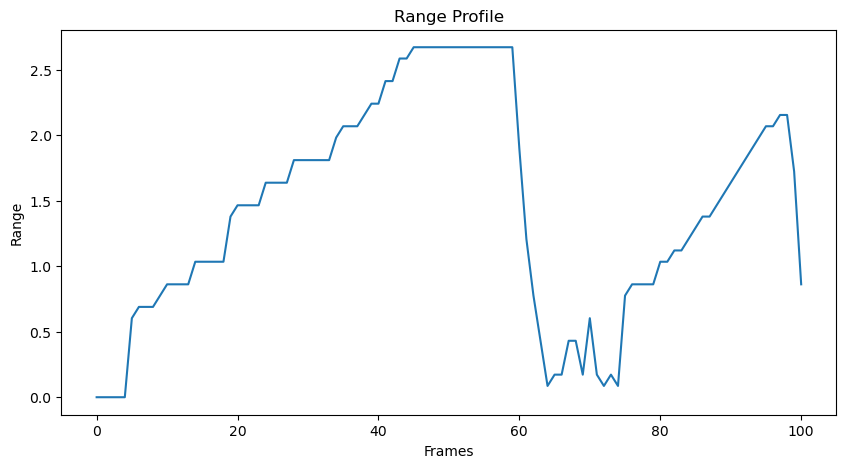

ABS Activated! 59


In [10]:
def ABS_Activation(output_dict):
    '''
    complete this part
    '''
    distance = Car_finder(output_dict)

    # If consecutive three frames have rapid decrease in distance, print an alert message
    threshold = 0.5
    for i in range(len(distance)-2):
        if distance[i] - distance[i+1] > threshold and distance[i+1] - distance[i+2] > threshold:
            print("ABS Activated!", i)


ABS_Activation(output_dict)   


## Postlab Assignments (Due Nov 8th):

### Postlab Assignment 1 (3 points). RF Motion Detector:
- write a program that tracks the movement of peaks in the range profiles across frames and detects motion. Your code should be able to say a motion is detected at what distance. Use your two corner reflectors to create peaks, shake one of the corner reflectors at a time and submit a video in addition to your script to show this in action.

##### Extra credit extension (2 extra points): make your RF motion detector work in real-time
- you will first need to write a code to detect if a new bin file is created by the radar.
- When a new bin file is created, process the bin file and tell if there is a motion.
Submit a video in addition to your script to show it in action.

### Postlab Assignment 2 (3 points): sending an alert to raspberry pi
- write a code that sends a UDP packet to the raspberry pi when a motion is detected. The alarm should be printed on the LED of the rPI. Submit a video in addition to your script to show this in action.

### Postlab Assignment 3 (4 points): tracking algorithm
- write a code to track the distance to two corner reflectors over frames. You can assume the movement direction of the corner reflectors don't change over frames, but you don't know whether they are approaching or moving away from the radar. plot the estimated distance of each corner reflector as a line across frames (one line per corner reflector), with the estimated distance on the y axis and frames on the x axis and two lines with two colors representing each corner reflector.
Submit a video in addition to your script to show it in action.

hint: You know that the movements are continuous.


[array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([7]), array([8]), array([8]), array([8]), array([9]), array([10]), array([10]), array([10]), array([10]), array([12]), array([12]), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([16]), array([17]), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([19]), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([21]), array([21]), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([23]), array([24]), array([24]), array([24]), array([25]), array([26]), array([], dtype=int64), array([28]), array([], dtype=int64), array([30]), array([30]), array([31]), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=in

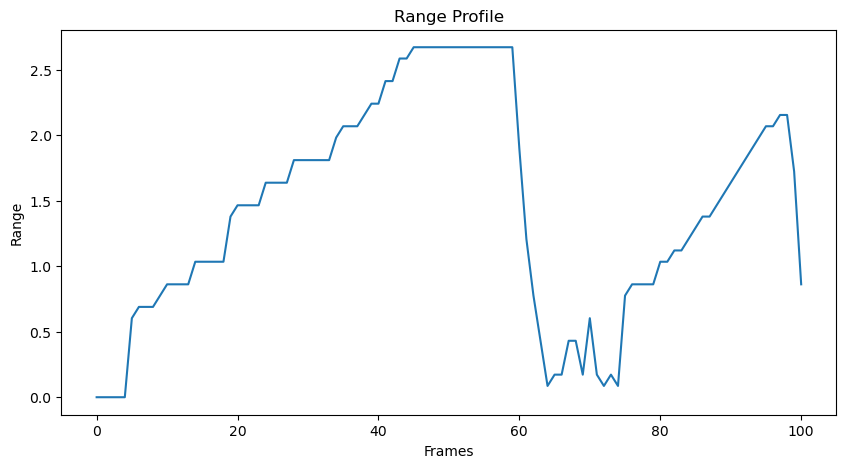

Motion Detected! 59


In [7]:
# write a program that tracks the movement of peaks in the range profiles across frames and detects motion. Your code should be able to say a motion is detected at what distance. Use your two corner reflectors to create peaks, shake one of the corner reflectors at a time and submit a video in addition to your script to show this in action.

#implement this function


def detect_file():
    new_file_name = ''
    file_list = os.listdir(binFilePath)
    while(True):
        file_list_new = os.listdir(binFilePath)
        if len(file_list_new) > len(file_list):
            #find the new file name
            for file in file_list_new:
                if file not in file_list:
                    new_file_name = file
                    return new_file_name
        sleep(3)

from time import sleep

def real_time_plot(file_name):
    while(True):
        plot_motion(parse_ADC(file_name))
        sleep(10)



# Send a UDP alter 
IP_addr = ''
def send_alter():
    sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
    sock.sendto(bytes("Motion Detected!", "utf-8"), (IP_addr, 12345))

def reciver():
    sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
    sock.bind((IP_addr, 12345))
    while(True):
        data, addr = sock.recvfrom(1024)
        print(data.decode("utf-8"))
